# Demo: NAS with graph morphisms

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import time
from torchviz import make_dot
import os

In [2]:
print("pytorch",torch.__version__)
print("cuda", torch.version.cuda)
print("cudnn", torch.backends.cudnn.version())
torch.cuda.is_available()


pytorch 1.3.1
cuda 10.0.130
cudnn 7605


True

## Set_up parameters and train/test functions

In [3]:
INPUT_SIZE = 28
INPUT_CHN = 1

N_CLASS = 10
N_EPOCH_TRAIN = 3

BATCH_SIZE = 100
LEARNING_RATE = 1e-4

MNIST_NAMES = "0123456789"

In [4]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
def train_net(net, optimizer, n_epoch=10, criterion=F.cross_entropy, display_interval=100,
             verbose=3):
    net.train(True)
    
    print("Training...")
    t0 = time.time()
    t00 = t0
    optimizer.zero_grad()

    for epoch in range(n_epoch):
        cumul_loss = 0.0
        running_loss = 0.0
        for batch_idx, (X, y) in enumerate(train_loader):
            X = X.cuda()
            y = y.cuda()

            y_pred = net(X)

            loss = criterion(y_pred, y)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            cumul_loss += loss.item()

            batch_idx += 1
            if batch_idx % display_interval == 0:
                running_loss /= display_interval
                t1 = time.time()
                if verbose >=3:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tt={:.1f}s'.format(
                        epoch, batch_idx * len(X), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), running_loss, t1-t0))
                running_loss = 0

        cumul_loss /= batch_idx
        t1 = time.time()
        if verbose>=2:
            print('====> Epoch: {} done in {:.1f}s, Average loss: {:.4f}'.format(
                epoch, t1-t0, cumul_loss))
        t0 = t1
    if verbose>=1:
        print('Training done, {} epochs in {:.1f}s, loss at last epoch: {:.4f}'.format(
            n_epoch, t1-t00, cumul_loss))

In [6]:
def test_net(net, use_train=False, criterion=F.cross_entropy, proba_extractor = lambda x:x):
    net.eval()

    if use_train:
        print("Evaluate net on TRAIN:")
        dataloader = train_loader
    else:
        print("Evaluate net on TEST:")
        dataloader = test_loader
    n_in_dataset = len(dataloader.dataset)
    
    cumul_loss = 0.0
    class_ok = 0
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            X = X.cuda()
            ground_truth = y.numpy()
            y = y.cuda()

            net_output = net(X)
            cumul_loss += criterion(net_output, y).item()
            
            y_soft = proba_extractor(net_output)
            _, y_hard = y_soft.max(1)

            prediction = y_hard.cpu().numpy()
            class_ok += np.sum(ground_truth == prediction)

    cumul_loss /= batch_idx+1
    accuracy = class_ok / n_in_dataset
    print("Well classified %5d / %5d, (%5.2f%% accuracy)" % (
        class_ok, n_in_dataset, 100*accuracy))
    print("Average loss : %f" % cumul_loss)
    return cumul_loss, accuracy

## Sample test
Just train a simple network to check that `train_net` and `test_net` work as expected, and get a baseline for what level of accuracy can be expected

In [7]:
loader = iter(train_loader)
X,y = loader.next()
X_=X.numpy()[:,0,:,:]

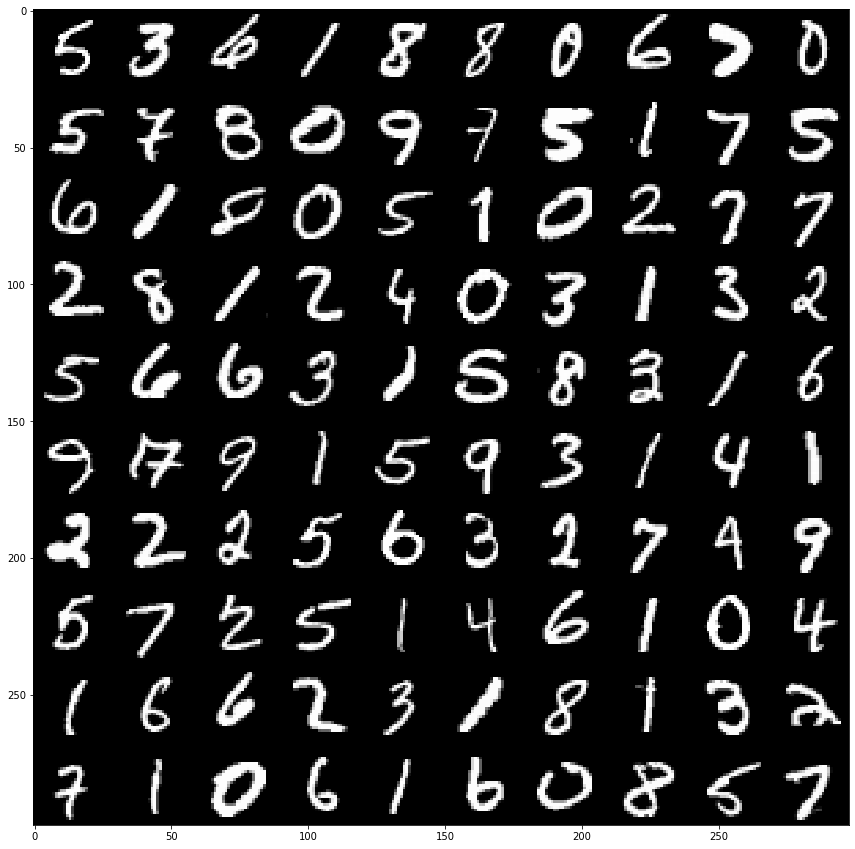

In [8]:
h, w = INPUT_SIZE, INPUT_SIZE
image = np.zeros(((h+2)*10-2, (w+2)*10-2))
img_labels = []
for ii in range(10):
    for jj in range(10):
        a = ii*(h+2)
        b = jj*(w+2)
        data = X_[jj+10*ii]
        image[a:a+h, b:b+w] = data
plt.figure(figsize=(15, 15))
plt.imshow(image,cmap='gray')

In [9]:
net01 = nn.Sequential(nn.Conv2d(1, 32, (5, 5), bias=True, padding=2, padding_mode='replicate'),
                    nn.ReLU(),
                    nn.MaxPool2d(2, stride=2),
                    nn.Conv2d(32, 64, (3, 3), bias=True, padding=1,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.Conv2d(64, 64, (3, 3), bias=True, padding=1,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.MaxPool2d(2, stride=2),
                    nn.Conv2d(64, 128, (3, 3), bias=True, padding=0,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.Flatten(),
                    nn.Linear(128*5*5, 1024), nn.ReLU(),
                    nn.Linear(1024, 10),
                    nn.Softmax(dim=1))
net01.cuda()
optimizer = optim.Adam(net01.parameters(), lr=LEARNING_RATE)

In [10]:
train_net(net01,optimizer, n_epoch=10)

Training...
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.0538	t=2.6s
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.7499	t=4.5s
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.7121	t=6.5s
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.6960	t=8.5s
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.6262	t=10.5s
Train Epoch: 0 [60000/60000 (100%)]	Loss: 1.6026	t=12.5s
====> Epoch: 0 done in 12.5s, Average loss: 1.7401
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.5862	t=2.0s
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.5165	t=4.0s
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.5073	t=6.0s
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.5039	t=7.9s
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.4969	t=9.9s
Train Epoch: 1 [60000/60000 (100%)]	Loss: 1.4938	t=11.9s
====> Epoch: 1 done in 11.9s, Average loss: 1.5174
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.4928	t=2.0s
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.4903	t=4.0s
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.4876	t=6.0s
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.4875	t=7.9s
T

In [11]:
test_net(net01, use_train=True)
test_net(net01, use_train=False)

Evaluate net on TRAIN:
Well classified 59517 / 60000, (99.19% accuracy)
Average loss : 1.469675
Evaluate net on TEST:
Well classified  9894 / 10000, (98.94% accuracy)
Average loss : 1.471674


(1.4716736114025115, 0.9894)

## Morphism turner
Use a variant of NNI Morphism tuner (which already contains everything needed)
The Bayesian optimizer is replaced by a simple hill climbing algorithm (as in [Elsken 2017](https://arxiv.org/pdf/1711.04528.pdf)) where the most accurate model on test set is repeatedely evolved into a generation of candidates that are trained for a few epochs (giving at each generation a new best candidate).

NNI toolbox natively saves only the model architectures without the weights. This defeats the purpose of *graph morphisms*, which is to speed-up training by re-using the weights. The `graph` and `graph_transform` packages of the toolbox, however, contain everything needed to morph graphs with weights properly handled. Some methods of the tuner are overloaded to allow network weights to be saved as a *.torch* file that goes along with the *json* file that describes the architecture.

In [12]:
from nni.networkmorphism_tuner.networkmorphism_tuner import NetworkMorphismTuner
from nni.networkmorphism_tuner.graph import graph_to_json, json_to_graph


In [13]:
from copy import deepcopy

from nni.utils import OptimizeMode
from nni.networkmorphism_tuner.graph_transformer import transform
from nni.networkmorphism_tuner.utils import Constant
from nni.networkmorphism_tuner.bayesian import SearchTree, edit_distance, contain
from nni.networkmorphism_tuner.networkmorphism_tuner import NetworkMorphismTuner


class HillClimbingOptimizer:
    """ A Bayesian optimizer for neural architectures.
    Attributes:
        gen_size
    """

    def __init__(self, tuner, gen_size=8):
        Constant.N_NEIGHBOURS = gen_size*2
        self.gen_size = gen_size
        self.searcher = tuner
        self.search_tree = SearchTree()
        self.generation_queue = []

    def fit(self, x_queue, y_queue):
        pass

    def generate(self, descriptors):
        """Generate new architecture.
        Args:
            descriptors: All the searched neural architectures.
        Returns:
            graph: An instance of Graph. A morphed neural network with weights.
            father_id: The father node ID in the search tree.
        """
        new_queue = []
        for _ in range(3):
            if new_queue:
                break

            father_id = self.searcher.get_best_model_id()
            graph = self.searcher.load_model_by_id(father_id, load_weights=True)
                
            for temp_graph in transform(graph):
                if contain(descriptors, temp_graph.extract_descriptor()):
                    continue
                descriptors.append(temp_graph.extract_descriptor())
                new_queue.append(temp_graph)
            new_queue = new_queue[:self.gen_size]
            
        if not new_queue:
            return None, None
        else:
            return new_queue, father_id

    def add_child(self, father_id, model_id):
        ''' add child to the search tree
        Arguments:
            father_id {int} -- father id
            model_id {int} -- model id
        '''

        self.search_tree.add_child(father_id, model_id)


class HillClimbingTuner(NetworkMorphismTuner):
    '''Overwrite the Bayesian optimizer in NetworkMorphismTuner
       with the Hill Climbing algorithm
    '''
    def __init__(self, **kwargs):
        gen_size = kwargs.pop("gen_size", 8)
        super(HillClimbingTuner, self).__init__(**kwargs)
        self.bo = HillClimbingOptimizer(self, gen_size)
        
    def generate_parameters(self, parameter_id, **kwargs):
        """
        Returns a set of trial neural architecture, as a serializable object.
        Parameters
        ----------
        parameter_id : int
        """
        if not self.history:
            self.init_search()

        new_father_id = None
        generated_graph = None
        if not self.training_queue:
            new_father_id, graph_list = self.generate()
            if type(graph_list) is not list:
                graph_list = [graph_list]
            for generated_graph in graph_list:
                new_model_id = self.model_count
                self.model_count += 1
                self.training_queue.append(
                    (generated_graph, new_father_id, new_model_id))
                self.descriptors.append(generated_graph.extract_descriptor())

        graph, father_id, model_id = self.training_queue.pop(0)

        # from graph to json
        json_out = self.save_weighted_graph(graph, model_id)
        self.total_data[parameter_id] = (json_out, father_id, model_id)

        return graph

    def load_model_by_id(self,father_id, load_weights=False):
        """Overload to work with weights"""
        graph = super(HillClimbingTuner,self).load_model_by_id(father_id)

        if load_weights and graph.weighted:
            weight_path = os.path.join(self.path, str(father_id) + ".torch")
            state_dict = torch.load(weight_path)
            model = graph.produce_torch_model()
            model.load_state_dict(state_dict)
            model.set_weight_to_graph()
            graph = model.graph
        return graph
    
    def update_from_model(self,model,parameter_id):
        _, father_id, model_id = self.total_data[parameter_id]
        json_out = self.save_weighted_graph(model.graph, model_id)
        self.total_data[parameter_id] = (json_out, father_id, model_id)

    def save_weighted_graph(self,graph, model_id):
        json_model_path = os.path.join(self.path, str(model_id) + ".json")
        json_out = graph_to_json(graph, json_model_path)
        if graph.weighted:
            weight_path = os.path.join(self.path, str(father_id) + ".torch")
            model = graph.produce_torch_model()
            state_dict = model.state_dict()
            torch.save(state_dict,weight_path)
        return json_out
    
    def receive_trial_result(self, parameter_id, value, model=None, **kwargs):
        if model is not None:
            self.update_from_model(model,parameter_id)
        super(HillClimbingTuner,self).receive_trial_result(parameter_id, None, value, **kwargs)

Use the tuner to minimise the loss function (maximizing accuracy is another option)

In [14]:
tuner = HillClimbingTuner(
    task = "cv",
    input_width = INPUT_SIZE,
    input_channel = INPUT_CHN,
    n_output_node = N_CLASS,
    optimize_mode = "minimize",
    path = "test00_model_path",
    gen_size = 8)

In [15]:
model_nb = 0
gen_id = 0
n_iter = 0
timing=[]
losses=[]
accuracies=[]
parameters=[]

if os.path.isdir(tuner.path):
    filesToRemove = [os.path.join(tuner.path,f) for f in os.listdir(tuner.path)]
    for f in filesToRemove:
        os.remove(f) 

In [16]:
t00 = time.time()
t0 = t00
while gen_id < 8 and n_iter < 80:
    print("\n=========================")
    parameter_id = "gen%02d_model%d"%(gen_id,model_nb)
    print("Iteration %d - %s - %ds elapsed"%(n_iter,parameter_id, t0-t00))
    
    graph = tuner.generate_parameters(parameter_id)
    model = graph.produce_torch_model().cuda()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_net(model, optimizer, n_epoch=N_EPOCH_TRAIN, verbose=1)
    loss, accuracy = test_net(model)
    model.cpu()
    
    tuner.receive_trial_result(parameter_id, loss, model)  
        
    parameters.append(parameter_id)
    print("Best model so far : %s (%d)"%(parameters[tuner.get_best_model_id()],tuner.get_best_model_id()))
    
    n_iter += 1
    if tuner.training_queue: 
        model_nb += 1
    else:
        gen_id += 1
        model_nb = 0
    
    
    t1=time.time()
    timing.append(t1-t0)
    t0=t1
    losses.append(loss)
    accuracies.append(accuracy)
tt = t1-t00
h = (tt)//3600
m = (tt - 3600*h)//60
s = (tt - 3600*h - 60*m)//1
print("******** DONE ********")
print("Full NAS search done in %dh %dm %ds seconds"%(h,m,s))


Iteration 0 - gen00_model0 - 0s elapsed
Training...
Training done, 3 epochs in 28.5s, loss at last epoch: 0.1528
Evaluate net on TEST:
Well classified  9757 / 10000, (97.57% accuracy)
Average loss : 0.085807
Best model so far : gen00_model0 (0)

Iteration 1 - gen01_model0 - 29s elapsed
Training...
Training done, 3 epochs in 33.2s, loss at last epoch: 0.1283
Evaluate net on TEST:
Well classified  9772 / 10000, (97.72% accuracy)
Average loss : 0.078697
Best model so far : gen01_model0 (1)

Iteration 2 - gen01_model1 - 63s elapsed
Training...
Training done, 3 epochs in 39.7s, loss at last epoch: 0.1411
Evaluate net on TEST:
Well classified  9758 / 10000, (97.58% accuracy)
Average loss : 0.082336
Best model so far : gen01_model0 (1)

Iteration 3 - gen01_model2 - 104s elapsed
Training...
Training done, 3 epochs in 31.4s, loss at last epoch: 0.1347
Evaluate net on TEST:
Well classified  9780 / 10000, (97.80% accuracy)
Average loss : 0.079323
Best model so far : gen01_model0 (1)

Iteration 4

Training done, 3 epochs in 65.2s, loss at last epoch: 0.0531
Evaluate net on TEST:
Well classified  9888 / 10000, (98.88% accuracy)
Average loss : 0.034856
Best model so far : gen04_model2 (27)

Iteration 31 - gen04_model6 - 1489s elapsed
Training...
Training done, 3 epochs in 64.5s, loss at last epoch: 0.0629
Evaluate net on TEST:
Well classified  9816 / 10000, (98.16% accuracy)
Average loss : 0.055719
Best model so far : gen04_model2 (27)

Iteration 32 - gen04_model7 - 1556s elapsed
Training...
Training done, 3 epochs in 71.1s, loss at last epoch: 0.0576
Evaluate net on TEST:
Well classified  9866 / 10000, (98.66% accuracy)
Average loss : 0.041390
Best model so far : gen04_model2 (27)

Iteration 33 - gen05_model0 - 1628s elapsed
Training...
Training done, 3 epochs in 91.2s, loss at last epoch: 0.0516
Evaluate net on TEST:
Well classified  9879 / 10000, (98.79% accuracy)
Average loss : 0.039230
Best model so far : gen04_model2 (27)

Iteration 34 - gen05_model1 - 1723s elapsed
Training

Search done in 3782s


Text(0.5, 0, 'Model ID')

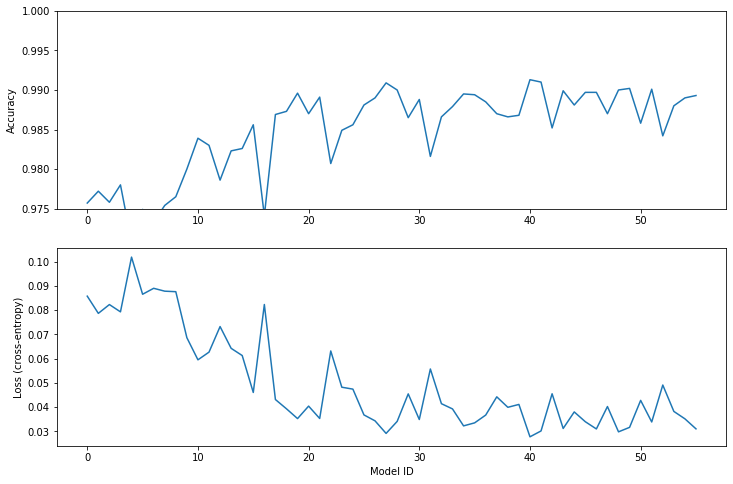

In [17]:
print("Search done in %ds"%sum(timing))

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(accuracies)
plt.ylabel("Accuracy")
plt.ylim(.975,1.)

plt.subplot(2,1,2)
plt.plot(losses);
plt.ylabel("Loss (cross-entropy)")
plt.xlabel("Model ID")

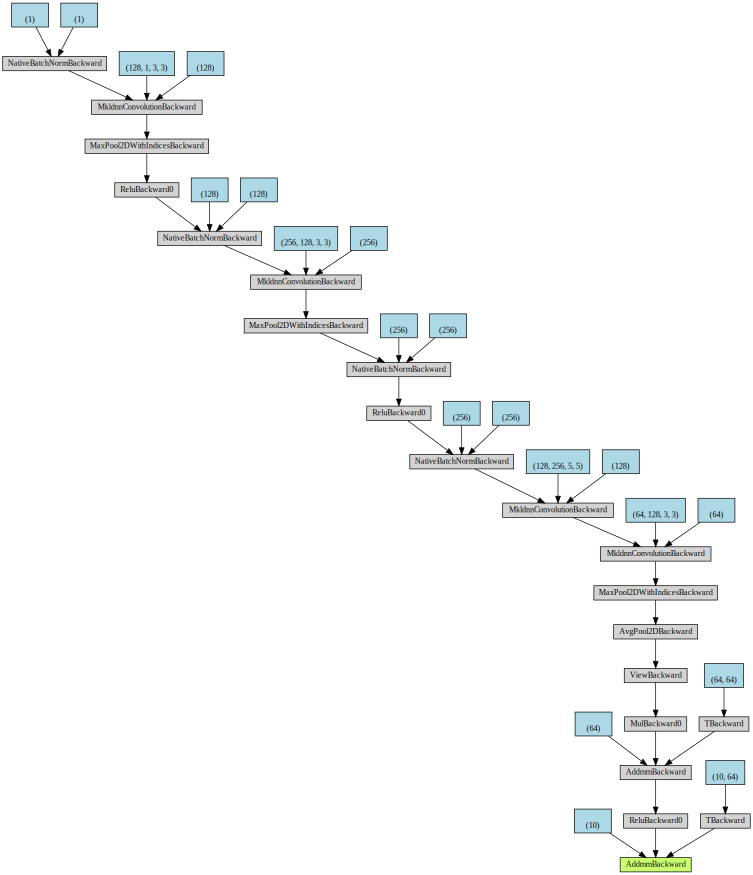

In [18]:
best_graph = tuner.load_best_model()
best_model = best_graph.produce_torch_model()

x,y = test_dataset[0]
x.unsqueeze_(0)
make_dot(best_model(x))